In [1]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import geopandas as gpd
from sqlalchemy import create_engine

In [2]:
spark = (
        SparkSession.builder
        .appName("NYTaxyData GeoAnalysis")
        .master("spark://spark-master:7077")
        .config("spark.driver.host", "jupyterlab")
        .config("spark.ui.port", "4040")
        .config("spark.driver.memory", "2g")
        .config("spark.executor.cores", "1")
        .config("spark.executor.memory", "4g")
        .config("spark.sql.adaptive.enabled", "true")
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true") 
        .config("spark.sql.shuffle.partitions", "8")
        .getOrCreate()
    )

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/25 12:51:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
BUCKET_NAME = "nyc-taxi-data" 
PROCESSED_DATA_PATH = f"s3a://{BUCKET_NAME}/processed/cleaned_yellow_taxi.parquet"
df = spark.read.parquet(PROCESSED_DATA_PATH)

25/06/25 12:51:45 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [4]:
TAXI_ZONE_LOOKUP_PATH = f"s3a://{BUCKET_NAME}/taxi_zones/taxi_zone_lookup.csv"
df_taxi_zones = spark.read.csv(TAXI_ZONE_LOOKUP_PATH, header=True, inferSchema=True)

In [5]:
pickup_counts = df.groupBy("pickup_zone").agg(count("*").alias("pickup_count"))

In [6]:
df_taxi_zones.show(5)

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
+----------+-------------+--------------------+------------+
only showing top 5 rows



In [7]:
pickup_counts.show(5)

+-----------+------------+
|pickup_zone|pickup_count|
+-----------+------------+
|        107|      718790|
|        186|     1284054|
|        148|      360047|
|        263|      666027|
|         70|      151802|
+-----------+------------+
only showing top 5 rows



In [6]:
pickup_counts = pickup_counts.join(df_taxi_zones, pickup_counts.pickup_zone == df_taxi_zones.LocationID, "left").select("pickup_zone", "pickup_count", "Borough", "Zone")
pickup_counts.show(5)

+-----------+------------+---------+-------------------+
|pickup_zone|pickup_count|  Borough|               Zone|
+-----------+------------+---------+-------------------+
|        233|      416939|Manhattan|UN/Turtle Bay South|
|        161|     1755723|Manhattan|     Midtown Center|
|        263|      666027|Manhattan|     Yorkville West|
|        261|      184436|Manhattan| World Trade Center|
|        107|      718790|Manhattan|           Gramercy|
+-----------+------------+---------+-------------------+
only showing top 5 rows



In [7]:
pickup_counts_pd = pickup_counts.toPandas()

In [27]:
pickup_counts_pd

,pickup_zone,pickup_count,Borough,Zone
0,107,718790,Manhattan,Gramercy
1,186,1284054,Manhattan,Penn Station/Madison Sq West
2,148,360047,Manhattan,Lower East Side
3,263,666027,Manhattan,Yorkville West
4,70,151802,Queens,East Elmhurst
...,...,...,...,...
257,30,22,Queens,Broad Channel
258,44,8,Staten Island,Charleston/Tottenville
259,187,4,Staten Island,Port Richmond
260,245,11,Staten Island,West Brighton


In [8]:
shapefile_path = "../data/taxi_zones/taxi_zones.shp"
gdf_zones = gpd.read_file(shapefile_path)
gdf_zones['LocationID'] = gdf_zones['LocationID'].astype(int)

In [26]:
gdf_zones

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824...."


In [9]:
merged_gdf = gdf_zones.merge(
        pickup_counts_pd, 
        left_on='LocationID', 
        right_on='pickup_zone', 
        how='left'
    )

In [10]:
merged_gdf['pickup_count'] = merged_gdf['pickup_count'].fillna(0)
merged_gdf


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,pickup_zone,pickup_count,Borough,Zone
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",1.0,1232.0,EWR,Newark Airport
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",2.0,53.0,Queens,Jamaica Bay
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2...",3.0,1045.0,Bronx,Allerton/Pelham Gardens
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4.0,38063.0,Manhattan,Alphabet City
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144...",NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ...",259.0,1227.0,Bronx,Woodlawn/Wakefield
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ...",260.0,6948.0,Queens,Woodside
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19...",261.0,184436.0,Manhattan,World Trade Center
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824....",262.0,461713.0,Manhattan,Yorkville East


In [11]:
columns_to_export = {
        'LocationID': 'location_id',
        'borough': 'borough',
        'zone': 'zone',
        'pickup_count': 'pickup_trip_count',
        'geometry': 'geometry' # The geometry column is essential for a spatial table
    }

final_gdf_to_save = merged_gdf[list(columns_to_export.keys())].rename(
        columns=columns_to_export
    )

final_gdf_to_save['pickup_trip_count'] = final_gdf_to_save['pickup_trip_count'].astype(int)

In [19]:
final_gdf_to_save

,location_id,borough,zone,pickup_trip_count,geometry
0,1,EWR,Newark Airport,1232,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,Queens,Jamaica Bay,53,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,Bronx,Allerton/Pelham Gardens,1045,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,Manhattan,Alphabet City,38063,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,Staten Island,Arden Heights,0,"POLYGON ((935843.31 144283.336, 936046.565 144..."
...,...,...,...,...,...
258,259,Bronx,Woodlawn/Wakefield,1227,"POLYGON ((1025414.782 270986.139, 1025138.624 ..."
259,260,Queens,Woodside,6948,"POLYGON ((1011466.966 216463.005, 1011545.889 ..."
260,261,Manhattan,World Trade Center,184436,"POLYGON ((980555.204 196138.486, 980570.792 19..."
261,262,Manhattan,Yorkville East,461713,"MULTIPOLYGON (((999804.795 224498.527, 999824...."


In [12]:
db_params = {
        "host": "postgres-gis",
        "port": "5432",
        "database": os.getenv("POSTGRES_DB"),
        "user": os.getenv("POSTGRES_USER"),
        "password": os.getenv("POSTGRES_PASSWORD")
    }

conn_string = (
            f"postgresql://{db_params['user']}:{db_params['password']}@"
            f"{db_params['host']}:{db_params['port']}/{db_params['database']}"
        )

engine = create_engine(conn_string)

final_gdf_to_save.to_postgis(
            name='pickup_hotspots',
            con=engine,
            if_exists='replace',
            index=False,
            schema='nyctaxi' 
        )


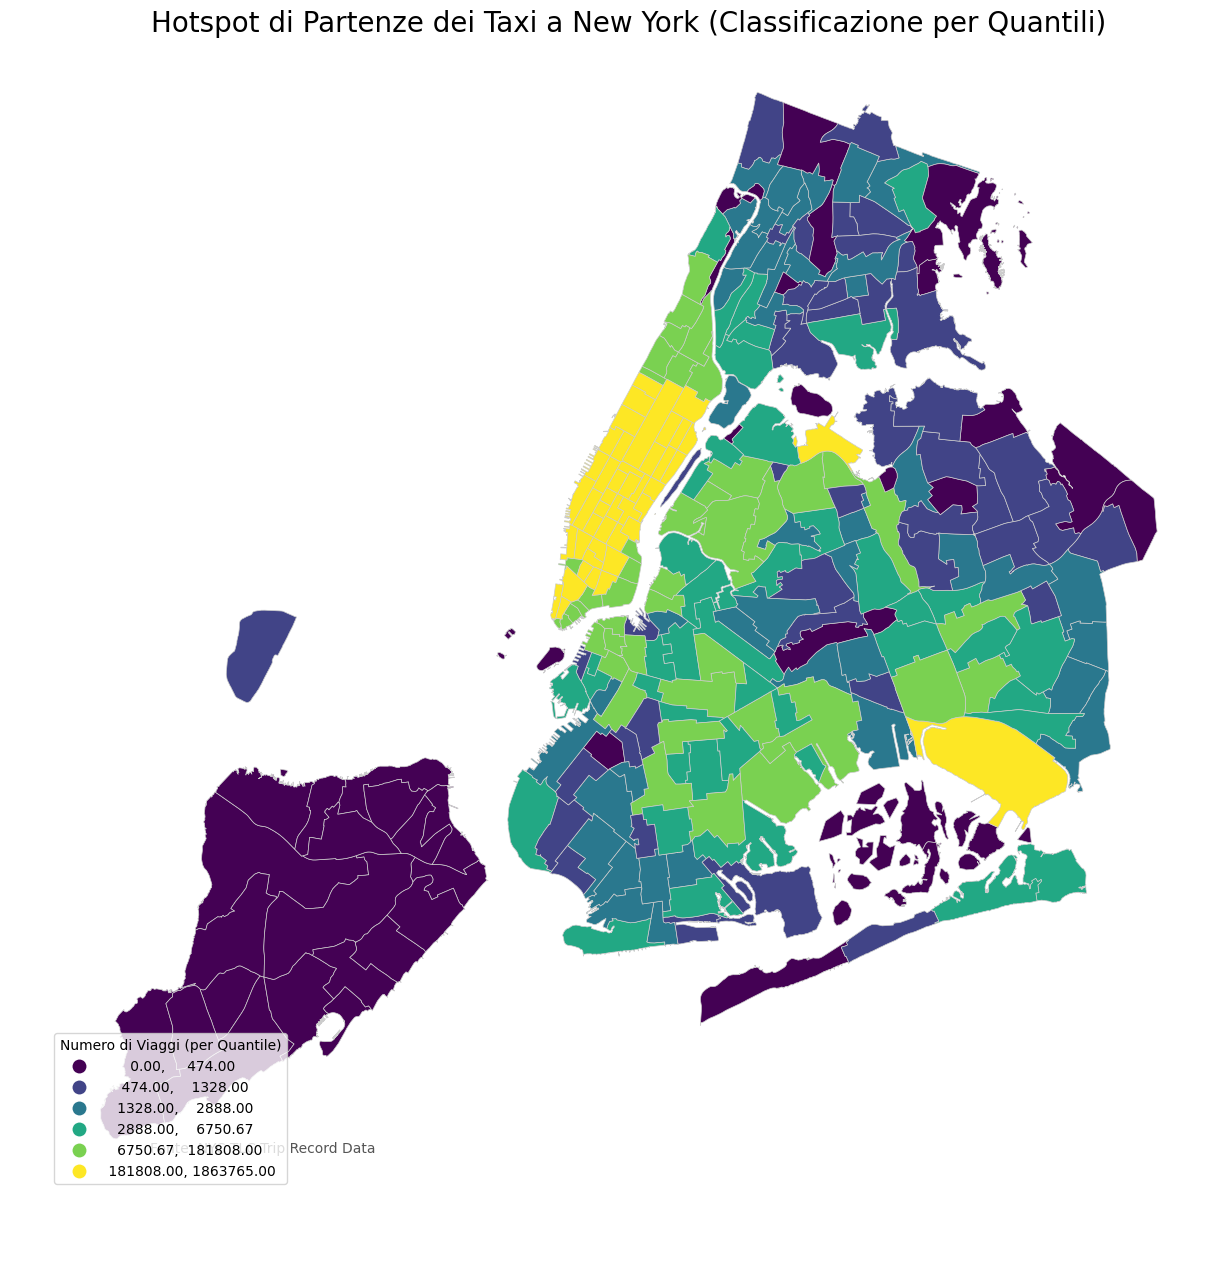

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
data_for_classification = merged_gdf[merged_gdf['pickup_count'] > 0]
merged_gdf.plot(
        column='pickup_count',
        ax=ax,
        linewidth=0.5,
        edgecolor='0.8',
        legend=True,
        scheme='Quantiles', # <--- THIS IS WHERE mapclassify IS USED
        k=6,               # <--- We are choosing 6 color bins
        legend_kwds={
            'title': "Numero di Viaggi (per Quantile)",
            'loc': 'lower left'
        }
    )
ax.set_title("Hotspot di Partenze dei Taxi a New York (Classificazione per Quantili)", 
                 fontdict={'fontsize': '20', 'fontweight': '3'})
ax.set_axis_off()

ax.annotate('Fonte: NYC TLC Trip Record Data',
                xy=(0.1, .08), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                fontsize=10, color='#555555')

plt.show()